### **Collect Image Using OpenCv**

In [1]:
import os
import uuid
import cv2
import time
import labelme

In [34]:
Image_path=os.path.join("data","images")
number_images = 30

In [ ]:
cap=cv2.VideoCapture(0)
for imagenum in range(number_images):
    print(f"Capture Image {imagenum}")
    ret,frame=cap.read()
    imagename=os.path.join(Image_path,f"{str(uuid.uuid1())}.jpeg")
    cv2.imwrite(imagename,frame)
    cv2.imshow("frame",frame)
    time.sleep(1)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### Annotate images with Lables

In [ ]:
!labelme

2024-04-21 19:38:21,796 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\abdul\.labelmerc


### **Review Dataset and Build Image Loadig Function**

In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np

In [3]:
#Set up CUDA
gpus=tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### Load image data into TF pipeline

In [ ]:
image_pipeline=tf.data.Dataset.list_files("data\\images\\*.jpeg",shuffle=False)

In [ ]:
image_pipeline.as_numpy_iterator().next()

b'data\\images\\10cfaad2-ffe8-11ee-a8a6-200b743244f1.jpeg'

In [6]:
def load_image(x):
    byte_image=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_image)
    return img

In [ ]:
images=image_pipeline.map(load_image)

In [ ]:
# from tensorflow.keras.preprocessing.image import array_to_img,load_img

In [ ]:
images.as_numpy_iterator().next()

array([[[72, 86, 89],
        [74, 85, 89],
        [75, 85, 87],
        ...,
        [83, 87, 90],
        [82, 86, 89],
        [83, 87, 90]],

       [[76, 90, 93],
        [76, 87, 89],
        [75, 85, 87],
        ...,
        [81, 85, 88],
        [81, 85, 88],
        [81, 85, 88]],

       [[79, 93, 94],
        [78, 90, 90],
        [76, 86, 87],
        ...,
        [78, 82, 85],
        [79, 83, 86],
        [80, 84, 87]],

       ...,

       [[54, 54, 54],
        [36, 36, 36],
        [31, 29, 30],
        ...,
        [32, 32, 30],
        [30, 31, 26],
        [28, 29, 24]],

       [[51, 51, 51],
        [34, 34, 34],
        [31, 30, 28],
        ...,
        [31, 31, 29],
        [29, 30, 25],
        [28, 29, 24]],

       [[48, 48, 48],
        [33, 33, 33],
        [31, 30, 28],
        ...,
        [30, 30, 28],
        [29, 30, 25],
        [29, 30, 25]]], dtype=uint8)

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

#### Visualize Image

In [ ]:
image_generator=images.batch(4).as_numpy_iterator()


In [ ]:

plot_image=image_generator.next()

In [ ]:
len(plot_image)
    

4

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(5,4))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(plot_image[i*2+j])
        ax[i,j].axis("off")
plt.show()

#### Partition Unaugmented Data

In [ ]:
train_path=r"data\train"
test_path=r"data\test"
val_path=r"data\val"

In [ ]:
import random

In [ ]:
path_list = os.listdir("data/images")  # Assuming "data/images" is your directory path
total_images = len(path_list)
train_count = 63
val_count = 14
test_count = 13

# Randomly select images for training set
train_set = random.sample(path_list, train_count)

# Remove selected images from path_list
remaining_images = [image for image in path_list if image not in train_set]

# Randomly select images for validation set
val_set = random.sample(remaining_images, val_count)

# Remove selected images from remaining_images
remaining_images = [image for image in remaining_images if image not in val_set]

# Randomly select images for test set
test_set = random.sample(remaining_images, test_count)
# Output the sets
print("Training set:", len(train_set))
print("Validation set:", len(val_set))
print("Test set:", len(test_set))

Training set: 63
Validation set: 14
Test set: 13


In [ ]:
label_path=os.listdir("data/labels")

In [ ]:
train_label_list=[]
for name in train_set:
    file_name = os.path.splitext(name)[0]
    for label in label_path:
        if file_name.startswith(label.split(".json")[0]):
            train_label_list.append(label)
            break
        

In [ ]:
val_label_list=[]
for name in val_set:
    file_name = os.path.splitext(name)[0]
    for label in label_path:
        if file_name.startswith(label.split(".json")[0]):
            val_label_list.append(label)
            break
        

In [ ]:
test_label_list=[]
for name in test_set:
    file_name = os.path.splitext(name)[0]
    for label in label_path:
        if file_name.startswith(label.split(".json")[0]):
            test_label_list.append(label)
            break

In [ ]:
len(train_label_list),len(test_label_list),len(val_label_list)

(58, 11, 10)

In [ ]:
len(label_path)

79

In [ ]:

58+11+10

79

In [ ]:
import shutil

In [ ]:
# For  Image And Label Split
def split_data(image_path,image_list,label_list):
    for entry in os.scandir(image_path):
        if entry.is_dir() and entry.name.endswith("images"):
            images_dir = entry.path
            for image_name in image_list:
                image_dir = os.path.join("data/images",image_name)
                shutil.copy(image_dir, images_dir)
        elif entry.is_dir() and entry.name.endswith("labels"):
            labels_dir = entry.path
            for label_name in label_list:
                label_dir=os.path.join("data/labels",label_name)
                shutil.copy(label_dir,labels_dir)
    return True

In [ ]:
split_data(train_path,train_set,train_label_list)
split_data(val_path,val_set,val_label_list)
split_data(test_path,test_set,test_label_list)

True

### **Apply Image Augmentation on images and labels using Albumention**

In [ ]:
import albumentations as alb

In [ ]:
augmentor=alb.Compose([alb.RandomCrop(width=450,height=450),
                       alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                      bbox_params=alb.BboxParams(format="albumentations",
                                                 label_fields=["class_label"]))

In [ ]:
#Test Annotation
img=cv2.imread(os.path.join("data","train","images","1f6a1e44-ffe8-11ee-85c0-200b743244f1.jpeg"))

In [ ]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
label=json.load(open(os.path.join("data","train","labels","1f6a1e44-ffe8-11ee-85c0-200b743244f1.json"),"r"))

In [ ]:
label["shapes"][0]["points"]

[[314.9074074074074, 205.74074074074076],
 [492.68518518518516, 390.9259259259259]]

In [ ]:
cords=[0,0,0,0]
cords[0]=label["shapes"][0]["points"][0][0]
cords[1]=label["shapes"][0]["points"][0][1]

cords[2]=label["shapes"][0]["points"][1][0]
cords[3]=label["shapes"][0]["points"][1][1]
print(cords)

[314.9074074074074, 205.74074074074076, 492.68518518518516, 390.9259259259259]


In [ ]:
cords=list(np.divide(cords,[640,480,640,480]))
cords

[0.49204282407407407,
 0.4286265432098766,
 0.7698206018518519,
 0.814429012345679]

In [ ]:
augmented=augmentor(image=img,bboxes=[cords],class_label=["face"])

In [ ]:
augmented

{'image': array([[[146, 158, 158],
         [147, 159, 159],
         [147, 159, 159],
         ...,
         [150, 147, 126],
         [148, 146, 125],
         [148, 145, 128]],
 
        [[145, 159, 159],
         [146, 160, 160],
         [145, 159, 159],
         ...,
         [148, 146, 125],
         [147, 145, 124],
         [147, 144, 126]],
 
        [[145, 159, 159],
         [146, 160, 160],
         [146, 160, 160],
         ...,
         [147, 145, 124],
         [146, 144, 123],
         [145, 143, 122]],
 
        ...,
 
        [[222, 216, 205],
         [217, 211, 201],
         [218, 212, 202],
         ...,
         [ 54,  78,  99],
         [ 54,  78,  99],
         [ 52,  78,  99]],
 
        [[224, 218, 208],
         [218, 212, 202],
         [217, 211, 201],
         ...,
         [ 54,  78,  99],
         [ 54,  78,  99],
         [ 52,  78,  99]],
 
        [[222, 216, 205],
         [215, 212, 201],
         [215, 212, 201],
         ...,
         [ 54,  78,

In [ ]:
augmented["class_label"]

['face']

In [ ]:
import numpy as np

cv2.rectangle(augmented["image"],
  tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
  tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
   (255,0,0), 2)
plt. imshow(cv2.cvtColor(augmented['image'],cv2.COLOR_BGR2RGB))


### **Build and Run Augmentation Pipeline**

In [ ]:

for partition in ["train","test","val"]: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_label=['face'])
                image_dir_path = os.path.join("aug_data", partition, "images")
                if not os.path.exists(image_dir_path):
                    os.makedirs(image_dir_path)
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
  
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                
                label_dir_path = os.path.join("aug_data", partition, "labels")
                if not os.path.exists(label_dir_path):
                    os.makedirs(label_dir_path)
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [7]:
## Load Augmented Images to Tensorflow Dataset
train_images=tf.data.Dataset.list_files("aug_data\\train\\images\\*.jpg",shuffle=False)
train_images=train_images.map(load_image)
train_images=train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images=train_images.map(lambda x: x/255.0)

In [8]:
test_images=tf.data.Dataset.list_files(r"aug_data\test\images\*.jpg",shuffle=False)
test_images=test_images.map(load_image)
test_images=test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images=test_images.map(lambda x: x/255.0)

In [9]:
val_images=tf.data.Dataset.list_files(r"aug_data\val\images\*.jpg",shuffle=False)
val_images=val_images.map(load_image)
val_images=val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images=val_images.map(lambda x: x/255.0)

In [ ]:
plt.imshow(train_images.as_numpy_iterator().next())

### **Prepare Label**

In [11]:
def load_label(label_path):
    label=json.load(open(label_path.numpy(),"r",encoding="utf-8"))
    return [label["class"]],label["bbox"]

In [12]:
train_label=tf.data.Dataset.list_files(r"aug_data\train\labels\*.json",shuffle=False)
train_label=train_label.map(lambda x: tf.py_function(load_label,[x],[tf.uint8,tf.float16]))

In [13]:
test_label=tf.data.Dataset.list_files(r"aug_data\test\labels\*.json",shuffle=False)
test_label=test_label.map(lambda x: tf.py_function(load_label,[x],[tf.uint8,tf.float16]))

In [14]:
val_label=tf.data.Dataset.list_files(r"aug_data\val\labels\*.json",shuffle=False)
val_label=val_label.map(lambda x: tf.py_function(load_label,[x],[tf.uint8,tf.float16]))

In [15]:
train_label.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.633 , 0.3535, 0.9824, 0.903 ], dtype=float16))

In [16]:
len(train_images),len(train_label),len(test_images),len(test_label),len(val_images),len(val_label)

(3780, 3780, 780, 780, 840, 840)

#### Create Final Dataset

In [17]:
train=tf.data.Dataset.zip((train_images,train_label))
train=train.shuffle(5000)
train=train.batch(8)
train=train.prefetch(4)# to hadle System BottleNeck

In [18]:
test=tf.data.Dataset.zip((test_images,test_label))
test=test.shuffle(1300)
test=test.batch(8)
test=test.prefetch(4)# to hadle System BottleNeck

In [19]:
val=tf.data.Dataset.zip((val_images,val_label))
val=val.shuffle(1000)
val=val.batch(8)
val=val.prefetch(4)# to hadle System BottleNeck

In [20]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.7046, 0.142 , 1.    , 0.6294],
        [0.    , 0.    , 0.5796, 0.844 ],
        [0.2185, 0.1924, 0.5723, 0.674 ],
        [0.4983, 0.14  , 0.8975, 0.6997],
        [0.546 , 0.2046, 0.968 , 0.7334],
        [0.57  , 0.324 , 0.9546, 0.8403],
        [0.1731, 0.1552, 0.533 , 0.6016]], dtype=float16))

In [21]:
train_batch=train.as_numpy_iterator()


In [22]:
res=train_batch.next()

In [23]:
res[0][0].shape

(120, 120, 3)

In [24]:
res[1][1][1]

array([0.3203, 0.1285, 0.7505, 0.682 ], dtype=float16)

In [25]:
sample_coords=res[1][1][2]
tuple(np.multiply(sample_coords[:2],[120,120]).astype(int))

(22, 4)

In [ ]:
## Viwe Image
fig,ax=plt.subplots(ncols=4,figsize=(10,10))
for idx in range(4):
    sample_image=res[0][idx]
    sample_coords=res[1][1][idx]
    # Convert the NumPy array to a UMat object
    sample_image_umat = cv2.UMat(sample_image)
    cv2.rectangle(sample_image_umat,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                  (255,0,0),2)
    # Convert the UMat object back to a NumPy array for displaying with matplotlib
    sample_image_with_rect = sample_image_umat.get()
    ax[idx].set_title(str(res[1][0][idx]))
    ax[idx].imshow(sample_image_with_rect)
plt.show()  

In [27]:
res[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2261, 0.1492, 0.625 , 0.723 ],
        [0.3203, 0.1285, 0.7505, 0.682 ],
        [0.1838, 0.0349, 0.515 , 0.4773],
        [0.722 , 0.1599, 1.    , 0.629 ],
        [0.    , 0.2434, 0.3918, 0.8174],
        [0.1741, 0.199 , 0.528 , 0.6807],
        [0.    , 0.1469, 0.3357, 0.5586],
        [0.    , 0.204 , 0.2656, 0.679 ]], dtype=float16))

### **Build Model**

#### Functional API

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [29]:
vgg=VGG16(include_top=False,weights="imagenet",classes=2)

In [30]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [78]:
def build_model():
    input_layer=Input(shape=(120,120,3))
    
    vgg=VGG16(include_top=False,weights='imagenet')(input_layer)
        
    f1= GlobalMaxPooling2D()(vgg)
    flat1=Flatten()(f1)
    classs1=Dense(2048,activation="ReLU")(flat1)
    classs2=Dense(1, activation="sigmoid")(classs1)
    
    f2=GlobalMaxPooling2D()(vgg)
    flat2=Flatten()(f2)
    reg1=Dense(2048, activation="ReLU")(flat2)
    reg2=Dense(4, activation="sigmoid")(reg1)
    
    FaceTracker=Model(inputs=input_layer, outputs=[classs2,reg2])
    return FaceTracker

#### Teset out Neural Network

In [79]:
FaceTracker=build_model()

In [80]:
FaceTracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [81]:
X,y=train.as_numpy_iterator().next()

In [95]:
X.shape

(8, 120, 120, 3)

In [97]:
classes, coords = FaceTracker.predict(X)

1/1 [==============================] - 53s 53s/step


In [98]:
classes, coords

(array([[0.49494436],
        [0.40639347],
        [0.4445166 ],
        [0.40090606],
        [0.46624416],
        [0.39886963],
        [0.44104144],
        [0.45189086]], dtype=float32),
 array([[0.43430734, 0.23069163, 0.46777973, 0.42772222],
        [0.4420351 , 0.3141792 , 0.38987586, 0.45596474],
        [0.4725512 , 0.31593767, 0.43777388, 0.45124245],
        [0.44481784, 0.3182874 , 0.4206873 , 0.40785214],
        [0.44634548, 0.24700366, 0.4160827 , 0.49307594],
        [0.44183394, 0.23718491, 0.46311462, 0.42013496],
        [0.45943668, 0.3049214 , 0.46803892, 0.42663047],
        [0.43892553, 0.2744431 , 0.50161296, 0.42648745]], dtype=float32))

### **Define Loss and Optimizers**

In [82]:
len(train)

473

In [83]:
batches_per_epoch=len(train)
lr_decay=(1./0.75 -1)/batches_per_epoch #leraningreate decrease gradually 

In [84]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=lr_decay)

In [85]:
##### Create Localization loss and classififcxation loss 
#```For Boundiong Box````
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [86]:
classloss=tf.keras.losses.BinaryCrossentropy()
regressorloss=localization_loss

In [99]:
## Test out loss metrics

In [100]:

localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7234006>

In [101]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.74988663>

In [103]:

regressorloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7234006>

#### **Train Model**

In [125]:
class Facetracker(Model): 
    def __init__(self, FaceTracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = FaceTracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X,training=False)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [126]:
tracker_model=Facetracker(FaceTracker)

In [127]:
tracker_model.compile(opt,classloss,regressorloss)

In [128]:
## Train

In [129]:
logdir='logs'

In [130]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [131]:
hist = tracker_model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


473/473 [==============================] - 62s 85ms/step - total_loss: 0.3652 - class_loss: 0.0840 - regress_loss: 0.3232 - val_total_loss: 0.1585 - val_class_loss: 0.0492 - val_regress_loss: 0.1339
Epoch 2/10
473/473 [==============================] - 42s 80ms/step - total_loss: 0.1443 - class_loss: 0.0396 - regress_loss: 0.1245 - val_total_loss: 0.0693 - val_class_loss: 0.0094 - val_regress_loss: 0.0646
Epoch 3/10
473/473 [==============================] - 42s 81ms/step - total_loss: 0.1078 - class_loss: 0.0285 - regress_loss: 0.0936 - val_total_loss: 0.0620 - val_class_loss: 0.0094 - val_regress_loss: 0.0573
Epoch 4/10
473/473 [==============================] - 42s 81ms/step - total_loss: 0.0607 - class_loss: 0.0146 - regress_loss: 0.0534 - val_total_loss: 0.0682 - val_class_loss: 0.0077 - val_regress_loss: 0.0643
Epoch 5/10
473/473 [==============================] - 42s 81ms/step - total_loss: 0.0497 - class_loss: 0.0096 - regress_loss: 0.0449 - val_total_loss: 0.1128 - val_class_l

In [132]:
hist.history

{'total_loss': [0.028569001704454422,
  0.024138623848557472,
  0.047318149358034134,
  0.02459545060992241,
  0.013377029448747635,
  0.004371095448732376,
  0.016665393486618996,
  0.00856536440551281,
  0.0022613494656980038,
  0.0015025733737275004],
 'class_loss': [0.00010716564429458231,
  0.00023551750928163528,
  0.013651474379003048,
  0.001878586015664041,
  6.1989571804588195e-06,
  0.002143941354006529,
  0.008773804642260075,
  0.00020568925538100302,
  3.242644379497506e-05,
  6.168018444441259e-05],
 'regress_loss': [0.028515418991446495,
  0.024020865559577942,
  0.04049241170287132,
  0.02365615777671337,
  0.013373930007219315,
  0.0032991247717291117,
  0.012278491631150246,
  0.008462519384920597,
  0.0022451363038271666,
  0.0014717333251610398],
 'val_total_loss': [0.15849579870700836,
  0.06929197907447815,
  0.061988379806280136,
  0.06818394362926483,
  0.11280407011508942,
  0.19364775717258453,
  0.15729646384716034,
  0.2052517682313919,
  0.2070318162441253

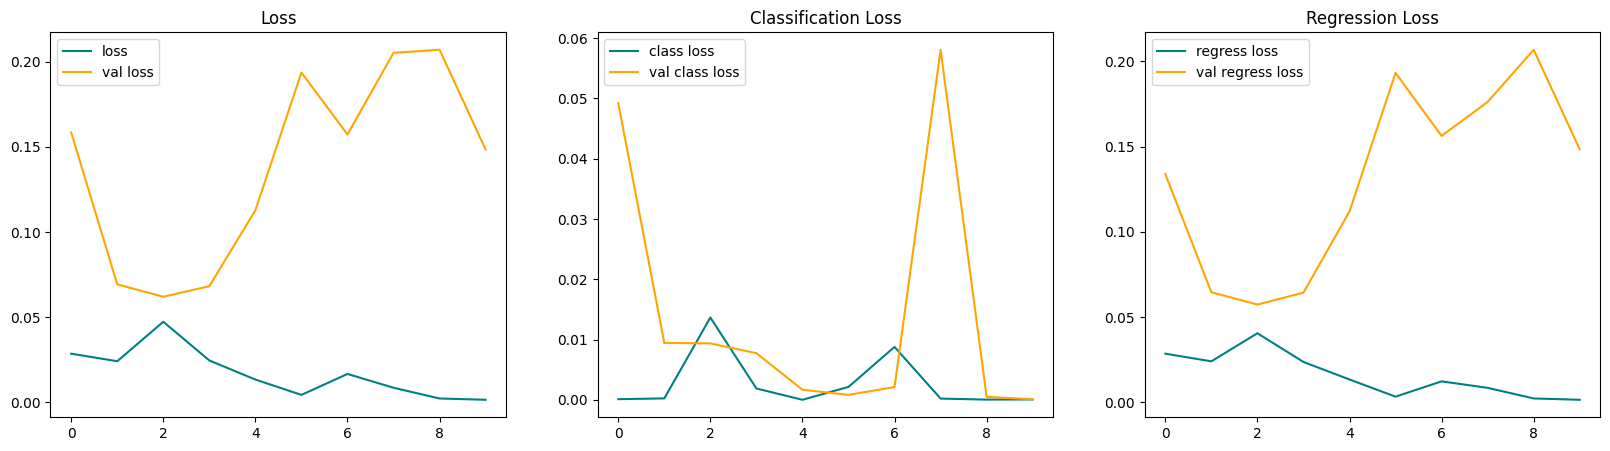

In [133]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


In [134]:
from tensorflow.keras.models import load_model

In [136]:
FaceTracker.save('facetracker.h5')

In [137]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()
yhat = FaceTracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    umat=cv2.UMat(sample_image)
    if yhat[0][idx] > 0.9:
        cv2.rectangle(umat, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    sample_image=umat.get()
    
    ax[idx].imshow(sample_image)

In [141]:
yhat

[array([[9.9981028e-01],
        [9.9998176e-01],
        [9.9980789e-01],
        [9.9999976e-01],
        [9.9963796e-01],
        [9.9998677e-01],
        [9.9999225e-01],
        [4.7668374e-05]], dtype=float32),
 array([[2.04652455e-02, 1.66609332e-01, 3.47766399e-01, 5.58486640e-01],
        [2.67572224e-01, 3.31879437e-01, 7.46470213e-01, 8.83076608e-01],
        [1.69479311e-01, 1.74095362e-01, 4.93384391e-01, 5.58300674e-01],
        [1.26699535e-02, 1.28202975e-01, 6.91447973e-01, 9.14419651e-01],
        [5.34039959e-02, 1.45055428e-01, 3.85059148e-01, 5.50551414e-01],
        [4.22875196e-01, 9.54255834e-02, 8.35563898e-01, 6.61579788e-01],
        [5.36596239e-01, 1.11275174e-01, 9.71458912e-01, 6.55468464e-01],
        [4.81032621e-04, 5.33573562e-04, 6.92026399e-04, 1.10031012e-03]],
       dtype=float32)]